In [1]:
import os, sys
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import torch
import pandas as pd 

# 0. Prepare Data

### specify the directories used for running the code:
* `data_dir`: where raw dataset is loaded; raw data is in csv format
* `processed_data_dir`: where processed dataset is loaded; processed data is in npy pickle format
    * processed data should be a ndarray of shape (participants_num x sessions_num(3) x days_per_session(10)*trail_per_day(4) x #examples_window*#mov(26*22=572) x processed_channel_num(252))
    * for instance: processed examples have shape **(5, 3, 40, 572, 252)** and labels have shape **(5, 3, 40, 572)**
* `path_<model_name>`: where model weights are saved
    * weights should be saved in folder `/Weights/<model_name>`. Each folder has subfolders containing weights for each participant.
    * weights for TSD model contain 3 set of training model. weights for DANN and SCADANN contain 2 set of trianing model (these two models are trianed based on TSD, so they do not have a best_state_0.pt model. 
* `save_<model_name>`: where model results are saved
    * each result for testing a model on a group of datset is saved in folder `results`. Each result has corresponding 
        * `<model_name>.txt` includes predictions, ground truths, array of accuracies for each participant and each session, and overall accuracy
        * `predictions_<model_name>.npy` includes array of accuracies, ground truths, predictions, and model outputs (probability array for each prediction)
        * remember to make blank files in these names before saving

* use `read_data_training` to process raw dataset

* `switch`=2 runs inter-day trainings
* use `sessions_to_include` to indicate which wearing location should be included. Due to the structure of training model, only one wearing location can be included. The default locaiton to include is Neutral. 
        

In [2]:
os.chdir("/home/laiy/gitrepos/msr_final/LongTermEMG_myo")
from PrepareAndLoadData.process_data import read_data_training

In [3]:
data_dir = "/home/laiy/gitrepos/msr_final/Wearable_Sensor_Long-term_sEMG_Dataset/data"
processed_data_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/Processed_datasets_all_across_day_loc_0"
code_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo"
save_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/Results"

path_TSD ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_across_day_loc_0/TSD"
save_TSD = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results"

path_DANN ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_across_day_loc_0/DANN"
save_DANN = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results"

path_SCADANN ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_across_day_loc_0/SCADANN"
save_SCADANN = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results"

In [4]:
# read_data_training(path=data_dir, store_path = processed_data_dir, num_participant=5, 
#                    sessions_to_include =[0], switch=2)

In [5]:
# check stored pickle 
with open(processed_data_dir + "/training_session.pickle", 'rb') as f:
    dataset_training = pickle.load(file=f)

examples_datasets_train = dataset_training['examples_training']
print('traning examples ', np.shape(examples_datasets_train))
labels_datasets_train = dataset_training['labels_training']
print('traning labels ', np.shape(labels_datasets_train))

traning examples  (5, 10, 4, 572, 252)
traning labels  (5, 10, 4, 572)


### Specify params used for training and testing

During training and testing, processed datasets are first put into pytorch dataloders, then feed to the model trainer; following are params for TSD model and dataloaders

* `num_kernels`: list of integers defining number of neurons used in each layer of linear block (linear block has `dropout`=0.5)
* `number_of_cycles_total`: number of trails performed for each session (assuming that all session have the same trail size)
    * 40 for myo
* `number_of_classes`: total number of gestures performed in dataset
    * 22 for myo
* `batch_size`: number of examples stored in each batch
* `feature_vector_input_length`: length of input array or each processed signal 
    * 252 for myo
* `learning_rate`= 0.002515
    

In [6]:
num_kernels=[200, 200, 200]                        # model layer size 
number_of_cycles_total=np.shape(examples_datasets_train[0][0])[0]               # #session
print("number_of_cycles_total ", number_of_cycles_total)
number_of_classes=22
batch_size=128          
feature_vector_input_length=252                     # size of one example 
learning_rate=0.002515

number_of_cycles_total  4


# 1. TSD_DNN
* `train_fine_tuning`: used to train data using TSD network only   
    * running this function will save three sets of TSD model weights (each is fine tuned based on the previous training)  
    
* `test_TSD_DNN_on_training_sessions`: test model result


### check if dataloaders are loaded correctly:
* each participant has shape (session_num x 40 x 572 x 252)
* each session has shape (40 x 572 x 252)
* put these data into on group ends up with shape (40*572=22880, 252)
    * shuffle on group of data and put into dataloaders
    * each participant should have 3 sets of dataloaders, each correspond to one session

In [7]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_standard import \
            test_TSD_DNN_on_training_sessions, train_fine_tuning

In [8]:
# train_fine_tuning(examples_datasets_train, labels_datasets_train,
#                   num_kernels=num_kernels, path_weight_to_save_to=path_TSD,
#                   number_of_classes=number_of_classes, number_of_cycles_total=number_of_cycles_total,
#                   batch_size=batch_size,
#                   feature_vector_input_length=feature_vector_input_length,
#                   learning_rate=learning_rate)

In [14]:
algo_name = "standard_TSD"
test_TSD_DNN_on_training_sessions(examples_datasets_train, labels_datasets_train,
                                  num_neurons=num_kernels, use_only_first_training=True,
                                  path_weights=path_TSD,
                                  feature_vector_input_length=feature_vector_input_length,
                                  save_path = save_TSD, algo_name=algo_name,
                                  number_of_cycles_total=number_of_cycles_total,
                                  number_of_classes=number_of_classes, cycle_for_test=3)

GET one participant_examples  (10, 4, 572, 252)
   GET one training_index_examples  (4, 572, 252)  at  0
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  1
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  2
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  3
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (20

       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  2
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  3
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  4
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  5
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (57

Participant:  4  Accuracy:  0.3758741258741259
8  SESSION   data =  572
Participant:  4  Accuracy:  0.4178321678321678
9  SESSION   data =  572
Participant:  4  Accuracy:  0.4423076923076923
ACCURACY PARTICIPANT  4 :  [0.9545454545454546, 0.701048951048951, 0.6853146853146853, 0.6800699300699301, 0.6520979020979021, 0.715034965034965, 0.3723776223776224, 0.3758741258741259, 0.4178321678321678, 0.4423076923076923]
[array([0.99125874, 0.78496503, 0.63461538, 0.78496503, 0.66433566,
       0.58391608, 0.65909091, 0.78496503, 0.57342657, 0.78146853]), array([0.98426573, 0.77972028, 0.73601399, 0.66258741, 0.81118881,
       0.70804196, 0.67482517, 0.65909091, 0.4965035 , 0.66608392]), array([0.97377622, 0.71678322, 0.61888112, 0.62762238, 0.50524476,
       0.54020979, 0.52097902, 0.54195804, 0.58566434, 0.52272727]), array([0.99125874, 0.66083916, 0.7534965 , 0.69405594, 0.62937063,
       0.5506993 , 0.5       , 0.50524476, 0.40909091, 0.48951049]), array([0.95454545, 0.70104895, 0.68531

In [15]:
results_filename = save_TSD + '/predictions_' + algo_name + "_no_retraining.npy"
results = np.load(results_filename, allow_pickle=True)
TSD_acc = results[0]
TSD_acc_overall = np.mean(TSD_acc)
TSD_df = pd.DataFrame(TSD_acc.transpose(), 
                       index = [f'Day_{i}' for i in range(TSD_acc.shape[1])],
                        columns = [f'Participant_{j}' for j in range(TSD_acc.shape[0])])
TSD_df

,Participant_0,Participant_1,Participant_2,Participant_3,Participant_4
Day_0,0.991259,0.984266,0.973776,0.991259,0.954545
Day_1,0.784965,0.77972,0.716783,0.660839,0.701049
Day_2,0.634615,0.736014,0.618881,0.753497,0.685315
Day_3,0.784965,0.662587,0.627622,0.694056,0.68007
Day_4,0.664336,0.811189,0.505245,0.629371,0.652098
Day_5,0.583916,0.708042,0.54021,0.550699,0.715035
Day_6,0.659091,0.674825,0.520979,0.5,0.372378
Day_7,0.784965,0.659091,0.541958,0.505245,0.375874
Day_8,0.573427,0.496503,0.585664,0.409091,0.417832
Day_9,0.781469,0.666084,0.522727,0.48951,0.442308


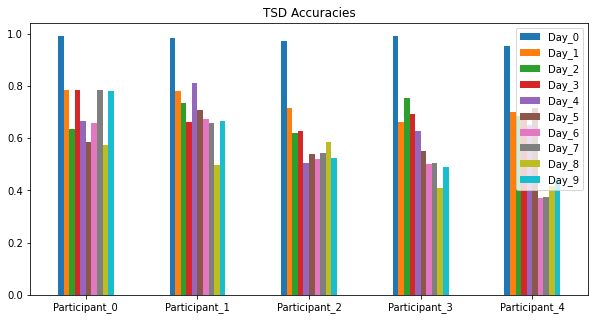

In [16]:
TSD_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("TSD Accuracies")
plt.show()

In [17]:
from TrainingsAndEvaluations.ForTrainingSessions.utils import get_gesture_accuracies

In [18]:
ground_truths = results[1]
predictions = results[2]
print("ground_truths  = ", np.shape(ground_truths))
print("predictions = ", np.shape(predictions))
m_name = "Loc0_Sub"
n_name = "Day"
df = get_gesture_accuracies(ground_truths, predictions, number_of_classes=number_of_classes, 
                            m_name=m_name, n_name=n_name, path=save_TSD, algo_name=algo_name)
df = pd.read_csv(save_TSD+'/'+algo_name+'.csv')
df

ground_truths  =  (5, 10)
predictions =  (5, 10)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =  (22, 26)
gestures pred =

,Unnamed: 0,Loc0_Sub0_Day0,Loc0_Sub0_Day1,Loc0_Sub0_Day2,Loc0_Sub0_Day3,Loc0_Sub0_Day4,Loc0_Sub0_Day5,Loc0_Sub0_Day6,Loc0_Sub0_Day7,Loc0_Sub0_Day8,...,Loc0_Sub4_Day0,Loc0_Sub4_Day1,Loc0_Sub4_Day2,Loc0_Sub4_Day3,Loc0_Sub4_Day4,Loc0_Sub4_Day5,Loc0_Sub4_Day6,Loc0_Sub4_Day7,Loc0_Sub4_Day8,Loc0_Sub4_Day9
0,M0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,M1,1.000000,0.384615,0.769231,1.000000,0.423077,0.961538,0.807692,0.923077,0.423077,...,0.884615,0.230769,0.730769,0.961538,1.000000,0.884615,1.000000,1.000000,1.000000,1.000000
2,M2,1.000000,1.000000,0.692308,1.000000,0.923077,1.000000,0.923077,0.807692,0.961538,...,1.000000,0.884615,0.692308,0.769231,1.000000,0.730769,0.500000,0.000000,0.000000,0.115385
3,M3,1.000000,1.000000,1.000000,0.961538,1.000000,1.000000,0.923077,1.000000,1.000000,...,1.000000,1.000000,0.923077,0.846154,0.730769,0.923077,0.423077,0.000000,0.000000,0.000000
4,M4,1.000000,0.153846,0.000000,0.384615,0.076923,0.615385,0.461538,0.230769,0.000000,...,0.923077,0.615385,0.076923,0.230769,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,M5,1.000000,1.000000,1.000000,0.884615,0.961538,1.000000,0.192308,1.000000,1.000000,...,1.000000,0.961538,1.000000,1.000000,1.000000,0.884615,0.576923,0.230769,0.961538,1.000000
6,M6,0.961538,1.000000,0.730769,1.000000,0.923077,0.846154,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.846154,0.923077,0.807692,0.038462,0.000000,0.000000,0.000000
7,M7,1.000000,1.000000,0.884615,1.000000,1.000000,0.730769,0.500000,0.884615,0.807692,...,1.000000,0.230769,0.192308,0.076923,0.769231,0.153846,0.000000,0.076923,0.000000,0.000000
8,M8,1.000000,1.000000,0.884615,1.000000,1.000000,0.500000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.884615,0.961538,0.884615,1.000000,0.769231,0.884615,0.961538,0.846154
9,M9,1.000000,0.807692,1.000000,1.000000,0.115385,0.115385,0.538462,1.000000,0.961538,...,0.884615,0.692308,0.653846,0.538462,0.576923,0.769231,0.000000,0.230769,0.192308,0.038462


# 2. DANN
* `train_DANN`: train DANN model using the first set of training weights from TSD model
    * two set of training weights will be saved
* `test_DANN_on_training_sessions`: test DANN model

In [14]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_DA import train_DANN, test_DANN_on_training_sessions

In [15]:
# train_DANN(examples_datasets_train, labels_datasets_train, 
#           num_kernels=num_kernels,
#           path_weights_fine_tuning=path_TSD,
#           number_of_classes=number_of_classes,
#           number_of_cycles_total = number_of_cycles_total,
#           batch_size=batch_size,
#           feature_vector_input_length=feature_vector_input_length,
#           path_weights_to_save_to=path_DANN, learning_rate=learning_rate)

In [16]:
algo_name = "DANN"
test_DANN_on_training_sessions(examples_datasets_train, labels_datasets_train,
                              feature_vector_input_length=feature_vector_input_length,
                              num_neurons=num_kernels, path_weights_DA=path_DANN,
                              algo_name=algo_name, save_path = save_DANN, 
                              number_of_cycles_total=number_of_cycles_total,
                              path_weights_normal=path_TSD, number_of_classes=number_of_classes,
                              cycle_for_test=3)

GET one participant_examples  (10, 4, 572, 252)
   GET one training_index_examples  (4, 572, 252)  at  0
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  1
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  2
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  3
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (20

       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  3
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  4
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  5
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  6
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (57

Participant ID:  4  Session ID:  2  Accuracy:  0.7552447552447552
Participant ID:  4  Session ID:  3  Accuracy:  0.7657342657342657
Participant ID:  4  Session ID:  4  Accuracy:  0.7517482517482518
Participant ID:  4  Session ID:  5  Accuracy:  0.8164335664335665
Participant ID:  4  Session ID:  6  Accuracy:  0.4527972027972028
Participant ID:  4  Session ID:  7  Accuracy:  0.4353146853146853
Participant ID:  4  Session ID:  8  Accuracy:  0.46853146853146854
Participant ID:  4  Session ID:  9  Accuracy:  0.5611888111888111
ACCURACY PARTICIPANT:  [0.9545454545454546, 0.7709790209790209, 0.7552447552447552, 0.7657342657342657, 0.7517482517482518, 0.8164335664335665, 0.4527972027972028, 0.4353146853146853, 0.46853146853146854, 0.5611888111888111]
[[0.99125874 0.77097902 0.73426573 0.77622378 0.68356643 0.62062937
  0.70454545 0.77272727 0.65734266 0.79370629]
 [0.98426573 0.85664336 0.78846154 0.8041958  0.84615385 0.75699301
  0.86538462 0.72552448 0.69755245 0.71853147]
 [0.97377622 0.7

In [17]:
results_filename = save_DANN + '/predictions_' + algo_name + ".npy"
results = np.load(results_filename, allow_pickle=True)
DANN_acc = results[0]
DANN_acc_overall = np.mean(DANN_acc)
DANN_df = pd.DataFrame(DANN_acc.transpose(), 
                       index = [f'Day_{i}' for i in range(DANN_acc.shape[1])],
                        columns = [f'Participant_{j}' for j in range(DANN_acc.shape[0])])
DANN_df

,Participant_0,Participant_1,Participant_2,Participant_3,Participant_4
Day_0,0.991259,0.984266,0.973776,0.991259,0.954545
Day_1,0.770979,0.856643,0.72028,0.664336,0.770979
Day_2,0.734266,0.788462,0.667832,0.751748,0.755245
Day_3,0.776224,0.804196,0.694056,0.692308,0.765734
Day_4,0.683566,0.846154,0.51049,0.652098,0.751748
Day_5,0.620629,0.756993,0.613636,0.573427,0.816434
Day_6,0.704545,0.865385,0.61014,0.51049,0.452797
Day_7,0.772727,0.725524,0.536713,0.548951,0.435315
Day_8,0.657343,0.697552,0.678322,0.452797,0.468531
Day_9,0.793706,0.718531,0.557692,0.505245,0.561189


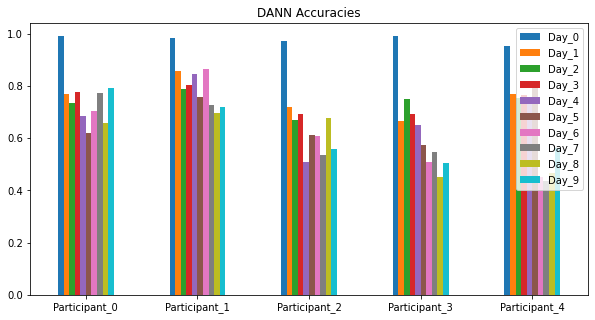

In [18]:
DANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("DANN Accuracies")
plt.show()

In [19]:
ground_truths = results[1]
predictions = results[2]
print("ground_truths  = ", np.shape(ground_truths))
print("predictions = ", np.shape(predictions))
m_name = "Loc0_Sub"
n_name = "Day"
df = get_gesture_accuracies(ground_truths, predictions, number_of_classes=number_of_classes, 
                            m_name=m_name, n_name=n_name, path=save_TSD, algo_name=algo_name)
df = pd.read_csv(save_TSD+'/'+algo_name+'.csv')
df

ground_truths  =  (5, 10)
predictions =  (5, 10)
accuracies_gestures =  (22, 50)


,Unnamed: 0,Loc0_Sub0_Day0,Loc0_Sub0_Day1,Loc0_Sub0_Day2,Loc0_Sub0_Day3,Loc0_Sub0_Day4,Loc0_Sub0_Day5,Loc0_Sub0_Day6,Loc0_Sub0_Day7,Loc0_Sub0_Day8,...,Loc0_Sub4_Day0,Loc0_Sub4_Day1,Loc0_Sub4_Day2,Loc0_Sub4_Day3,Loc0_Sub4_Day4,Loc0_Sub4_Day5,Loc0_Sub4_Day6,Loc0_Sub4_Day7,Loc0_Sub4_Day8,Loc0_Sub4_Day9
0,M0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,M1,1.000000,0.115385,0.961538,0.807692,0.076923,0.961538,0.653846,0.769231,0.384615,...,0.884615,0.538462,1.000000,1.000000,1.000000,1.000000,0.884615,0.961538,1.000000,0.923077
2,M2,1.000000,0.961538,0.269231,1.000000,1.000000,0.923077,0.846154,0.115385,0.923077,...,1.000000,0.807692,0.692308,0.846154,0.923077,0.769231,0.346154,0.000000,0.423077,0.538462
3,M3,1.000000,1.000000,1.000000,0.961538,0.961538,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.923077,0.923077,0.846154,0.807692,0.923077,0.384615,0.000000,0.000000,0.461538
4,M4,1.000000,0.038462,0.000000,0.153846,0.038462,0.653846,0.500000,0.038462,0.076923,...,0.923077,1.000000,0.730769,0.653846,0.538462,0.500000,0.769231,0.000000,0.000000,0.461538
5,M5,1.000000,1.000000,0.807692,0.884615,0.961538,0.923077,0.346154,1.000000,1.000000,...,1.000000,0.961538,1.000000,0.961538,1.000000,0.923077,0.923077,0.846154,1.000000,0.807692
6,M6,0.961538,1.000000,0.961538,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.923077,1.000000,1.000000,0.038462,0.076923,0.000000,0.000000
7,M7,1.000000,0.961538,0.846154,1.000000,1.000000,0.576923,0.961538,0.846154,0.923077,...,1.000000,0.384615,0.192308,0.076923,0.461538,0.423077,0.000000,0.115385,0.000000,0.000000
8,M8,1.000000,1.000000,0.769231,1.000000,0.884615,0.615385,1.000000,1.000000,1.000000,...,1.000000,0.846154,0.884615,0.961538,0.884615,0.846154,0.538462,0.115385,0.923077,0.730769
9,M9,1.000000,0.846154,0.961538,1.000000,0.038462,0.000000,0.769231,1.000000,0.692308,...,0.884615,0.269231,0.538462,0.076923,0.153846,0.576923,0.000000,0.269231,0.346154,0.000000


# 3. SCADANN
* `run_SCADANN_training_sessions`: train SCADANN model. The first session uses TSD model_0 wegits; others use DANN weights
    * specify `percentage_same_gesture_stable` based on the performance of most pseudo labels 
        * print accuracies out and check what percentage will optimize `ACCURACY MODEL` and `ACCURACY PSEUDO` without cutting out too much data 
    * two set of training weights will be saved
* `test_network_SLADANN`: test DANN model

In [20]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_SCADANN import run_SCADANN_training_sessions, test_network_SLADANN

In [21]:
# percentage_same_gesture_stable = 0.75 
# run_SCADANN_training_sessions(examples_datasets=examples_datasets_train, labels_datasets=labels_datasets_train,
#                               num_kernels=num_kernels, feature_vector_input_length=feature_vector_input_length,
#                               path_weights_to_save_to=path_SCADANN,
#                               path_weights_Adversarial_training=path_DANN,
#                               path_weights_Normal_training=path_TSD,
#                               number_of_cycles_total = number_of_cycles_total, 
#                               number_of_classes=number_of_classes,
#                               learning_rate=learning_rate)

In [22]:
algo_name = "SCADANN"
test_network_SLADANN(examples_datasets_train=examples_datasets_train, labels_datasets_train=labels_datasets_train,
                     num_neurons=num_kernels, feature_vector_input_length=feature_vector_input_length,
                     path_weights_SCADANN =path_SCADANN, path_weights_normal=path_TSD,
                     algo_name=algo_name, cycle_test=3, number_of_cycles_total=number_of_cycles_total,
                     number_of_classes=number_of_classes, save_path = save_SCADANN)

GET one participant_examples  (10, 4, 572, 252)
   GET one training_index_examples  (4, 572, 252)  at  0
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  1
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  2
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  3
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (20

   GET one training_index_examples  (4, 572, 252)  at  5
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  6
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  7
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (229, 252)
   GET one training_index_examples  (4, 572, 252)  at  8
   GOT one group XY  (2288, 252)    (2288,)
       one group XY test  (572, 252)    (572, 252)
       one group XY train (2059, 252)    (2059,)
       one group XY valid (229, 252)    (22

In [23]:
results_filename = save_SCADANN + '/predictions_' + algo_name + ".npy"
results = np.load(results_filename, allow_pickle=True)
SCADANN_acc = results[0]
SCADANN_acc_overall = np.mean(SCADANN_acc)
SCADANN_df = pd.DataFrame(SCADANN_acc.transpose(), 
                       index = [f'Day_{i}' for i in range(SCADANN_acc.shape[1])],
                        columns = [f'Participant_{j}' for j in range(SCADANN_acc.shape[0])])
SCADANN_df

,Participant_0,Participant_1,Participant_2,Participant_3,Participant_4
Day_0,0.991259,0.984266,0.973776,0.991259,0.954545
Day_1,0.762238,0.881119,0.751748,0.704545,0.81993
Day_2,0.788462,0.84965,0.72028,0.807692,0.835664
Day_3,0.772727,0.832168,0.73951,0.767483,0.800699
Day_4,0.727273,0.893357,0.559441,0.694056,0.812937
Day_5,0.645105,0.793706,0.646853,0.601399,0.846154
Day_6,0.722028,0.933566,0.603147,0.559441,0.550699
Day_7,0.816434,0.763986,0.59965,0.596154,0.496503
Day_8,0.687063,0.716783,0.690559,0.468531,0.491259
Day_9,0.847902,0.763986,0.59965,0.568182,0.646853


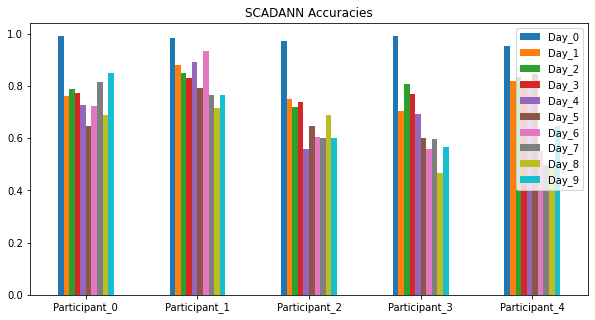

In [24]:
SCADANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("SCADANN Accuracies")
plt.show()

In [25]:
ground_truths = results[1]
predictions = results[2]
print("ground_truths  = ", np.shape(ground_truths))
print("predictions = ", np.shape(predictions))
m_name = "Loc0_Sub"
n_name = "Day"
df = get_gesture_accuracies(ground_truths, predictions, number_of_classes=number_of_classes, 
                            m_name=m_name, n_name=n_name, path=save_TSD, algo_name=algo_name)
df = pd.read_csv(save_TSD+'/'+algo_name+'.csv')
df

ground_truths  =  (5, 10)
predictions =  (5, 10)
accuracies_gestures =  (22, 50)


,Unnamed: 0,Loc0_Sub0_Day0,Loc0_Sub0_Day1,Loc0_Sub0_Day2,Loc0_Sub0_Day3,Loc0_Sub0_Day4,Loc0_Sub0_Day5,Loc0_Sub0_Day6,Loc0_Sub0_Day7,Loc0_Sub0_Day8,...,Loc0_Sub4_Day0,Loc0_Sub4_Day1,Loc0_Sub4_Day2,Loc0_Sub4_Day3,Loc0_Sub4_Day4,Loc0_Sub4_Day5,Loc0_Sub4_Day6,Loc0_Sub4_Day7,Loc0_Sub4_Day8,Loc0_Sub4_Day9
0,M0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,M1,1.000000,0.000000,1.000000,0.846154,0.000000,1.000000,0.961538,0.884615,0.115385,...,0.884615,0.692308,1.000000,1.000000,1.000000,1.000000,0.961538,0.961538,1.000000,0.884615
2,M2,1.000000,1.000000,0.346154,1.000000,1.000000,1.000000,1.000000,0.000000,0.961538,...,1.000000,1.000000,0.730769,1.000000,1.000000,0.923077,0.500000,0.000000,0.384615,0.538462
3,M3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.923077,0.923077,0.961538,0.807692,0.000000,0.076923,0.576923
4,M4,1.000000,0.000000,0.000000,0.000000,0.000000,0.884615,0.576923,0.000000,0.076923,...,0.923077,1.000000,0.884615,0.576923,0.769231,0.692308,0.961538,0.038462,0.000000,0.500000
5,M5,1.000000,1.000000,1.000000,0.923077,1.000000,0.961538,0.384615,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.961538,0.961538,0.884615,1.000000,1.000000,1.000000,1.000000
6,M6,0.961538,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.076923,0.000000,0.000000
7,M7,1.000000,1.000000,0.961538,1.000000,1.000000,0.769231,1.000000,1.000000,1.000000,...,1.000000,0.384615,0.346154,0.153846,0.153846,0.730769,0.000000,0.769231,0.000000,0.038462
8,M8,1.000000,1.000000,1.000000,1.000000,1.000000,0.653846,1.000000,1.000000,1.000000,...,1.000000,0.961538,0.884615,0.961538,0.961538,0.923077,0.615385,0.769231,1.000000,0.846154
9,M9,1.000000,1.000000,1.000000,1.000000,0.000000,0.038462,0.884615,1.000000,0.961538,...,0.884615,0.076923,0.692308,0.000000,0.000000,0.115385,0.000000,0.076923,0.230769,0.000000


# Conclusion
In general, overall accuracies of SCADANN is better than DANN, and DANN is better than TSD.   

Occasionally accuracies of SCADANN ends up a little smaller than DANN, reasons may be lack of datasets put into training model (fixed) and non-optimal percentage_same_gesture_sable (fixed). Code should be reproducable if processed dataset stick to the shape defined above.

* What to check if sth goes wrong:
    * percentage_same_gesture_sable
    * number of cycles or sessions
    * shape of dataloaders (combination of train, test, valid should include all dataset)
    * shape of procssed datasets
    * directory paths of weights and results
    * if weights are stored or loaded correclty

In [26]:
print("TSD")
display(TSD_df)
print("DANN")
display(DANN_df)
print("SCADANN")
display(SCADANN_df)

TSD


,Participant_0,Participant_1,Participant_2,Participant_3,Participant_4
Day_0,0.991259,0.984266,0.973776,0.991259,0.954545
Day_1,0.784965,0.77972,0.716783,0.660839,0.701049
Day_2,0.634615,0.736014,0.618881,0.753497,0.685315
Day_3,0.784965,0.662587,0.627622,0.694056,0.68007
Day_4,0.664336,0.811189,0.505245,0.629371,0.652098
Day_5,0.583916,0.708042,0.54021,0.550699,0.715035
Day_6,0.659091,0.674825,0.520979,0.5,0.372378
Day_7,0.784965,0.659091,0.541958,0.505245,0.375874
Day_8,0.573427,0.496503,0.585664,0.409091,0.417832
Day_9,0.781469,0.666084,0.522727,0.48951,0.442308


DANN


,Participant_0,Participant_1,Participant_2,Participant_3,Participant_4
Day_0,0.991259,0.984266,0.973776,0.991259,0.954545
Day_1,0.770979,0.856643,0.72028,0.664336,0.770979
Day_2,0.734266,0.788462,0.667832,0.751748,0.755245
Day_3,0.776224,0.804196,0.694056,0.692308,0.765734
Day_4,0.683566,0.846154,0.51049,0.652098,0.751748
Day_5,0.620629,0.756993,0.613636,0.573427,0.816434
Day_6,0.704545,0.865385,0.61014,0.51049,0.452797
Day_7,0.772727,0.725524,0.536713,0.548951,0.435315
Day_8,0.657343,0.697552,0.678322,0.452797,0.468531
Day_9,0.793706,0.718531,0.557692,0.505245,0.561189


SCADANN


,Participant_0,Participant_1,Participant_2,Participant_3,Participant_4
Day_0,0.991259,0.984266,0.973776,0.991259,0.954545
Day_1,0.762238,0.881119,0.751748,0.704545,0.81993
Day_2,0.788462,0.84965,0.72028,0.807692,0.835664
Day_3,0.772727,0.832168,0.73951,0.767483,0.800699
Day_4,0.727273,0.893357,0.559441,0.694056,0.812937
Day_5,0.645105,0.793706,0.646853,0.601399,0.846154
Day_6,0.722028,0.933566,0.603147,0.559441,0.550699
Day_7,0.816434,0.763986,0.59965,0.596154,0.496503
Day_8,0.687063,0.716783,0.690559,0.468531,0.491259
Day_9,0.847902,0.763986,0.59965,0.568182,0.646853


In [27]:
diff_df = SCADANN_df-TSD_df
diff_df = diff_df.drop('Day_0')
display(diff_df)
diff_df.to_csv(save_TSD+'/diff_results/across_day_loc0_diff.csv')

,Participant_0,Participant_1,Participant_2,Participant_3,Participant_4
Day_1,-0.022727,0.101399,0.034965,0.043706,0.118881
Day_2,0.153846,0.113636,0.101399,0.054196,0.15035
Day_3,-0.012238,0.16958,0.111888,0.073427,0.120629
Day_4,0.062937,0.082168,0.054196,0.064685,0.160839
Day_5,0.061189,0.085664,0.106643,0.050699,0.131119
Day_6,0.062937,0.258741,0.082168,0.059441,0.178322
Day_7,0.031469,0.104895,0.057692,0.090909,0.120629
Day_8,0.113636,0.22028,0.104895,0.059441,0.073427
Day_9,0.066434,0.097902,0.076923,0.078671,0.204545


In [28]:
overall_acc_df = pd.DataFrame([TSD_acc_overall, DANN_acc_overall, SCADANN_acc_overall],
                             index = ["TSD", "DANN", "SCADANN"],
                             columns = ["Overall_Acc"])
overall_acc_df

,Overall_Acc
TSD,0.655105
DANN,0.703741
SCADANN,0.741434


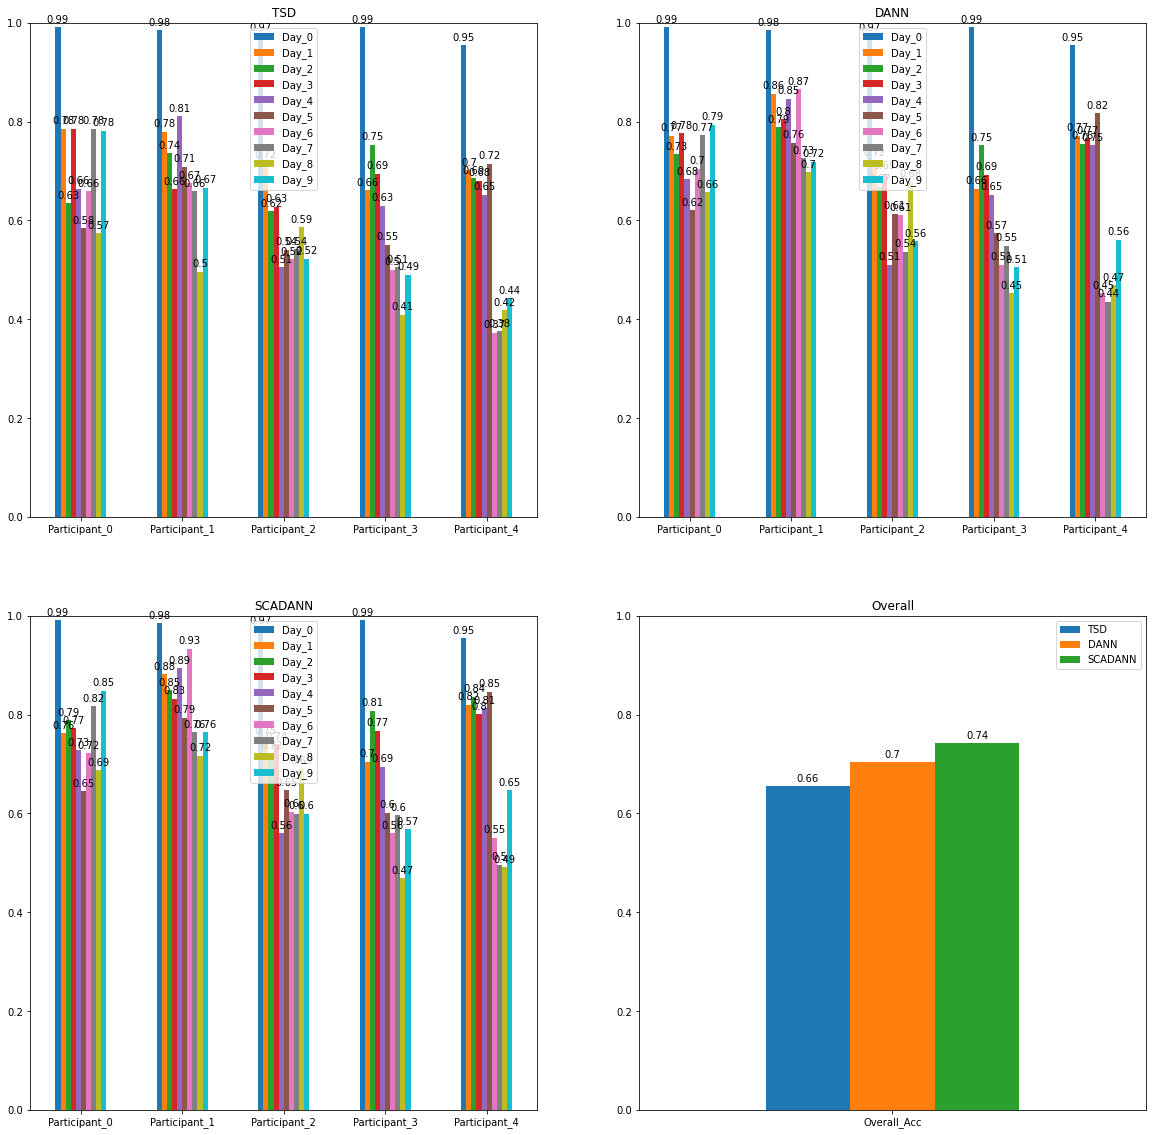

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
acc_list = [TSD_df, DANN_df, SCADANN_df, overall_acc_df]
title_list = ["TSD", "DANN", "SCADANN", "Overall"]
for idx, ax in enumerate(axes.reshape(-1)): 
    acc_list[idx].transpose().plot.bar(ax = ax, rot=0)
    ax.set_title(title_list[idx])
    ax.set_ylim([0, 1.0])
    for p in ax.patches:
        ax.annotate(str(np.round(p.get_height(),2)), (p.get_x()+p.get_width()/2., p.get_height()),
                    ha='center', va='center', xytext=(0, 8),textcoords='offset points')
fig.savefig("/home/laiy/gitrepos/msr_final/code/test_code/img/myo_results.jpg")